In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
import gc
import warnings
import collections
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_curve,\
                            roc_auc_score,\
                            precision_score, \
                            recall_score,\
                            accuracy_score, \
                            f1_score, \
                            confusion_matrix, \
                            auc, \
                            classification_report, \
                            plot_confusion_matrix,\
                            plot_roc_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [ ]:
def delete_high_corre(data: pd.DataFrame, p):
    corr = data.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > p)]
    return drop_list


def percent_null(data):
    x = data.isnull().sum()
    count = len(data)
    x = pd.DataFrame(x, columns=['number_null'])
    x['percent'] = round((x['number_null'] / count) * 100, 2)
    return x


def reduce_group(dataframe, group, c="v"):
    use = []
    for g in group:
        mx = 0
        vx = g[0]
        for j in g:
            n = dataframe[c + str(j)].nunique()
            if n > mx:
                mx = n
                vx = j
        use.append(vx)
    m = 0
    while m < len(group):
        for i in group[m]:
            if i not in use:
                del df['v' + str(i)]
        m += 1
    return dataframe


class Fraud_detection:
    def __init__(self, df):
        self._df = df

    def read_data(self):
        self._df.columns = [col.lower() for col in self._df.columns]
        self._df = self._df.drop_duplicates()
        return self._df

    def reduce_mem_usage(self, verbose=True):
        # các loại dtype
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        start_mem = self._df.memory_usage().sum() / 1024 ** 2
        for col in self._df.columns:
            col_type = self._df[col].dtypes
            if col_type in numerics:
                c_min = self._df[col].min()
                c_max = self._df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        self._df[col] = self._df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        self._df[col] = self._df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        self._df[col] = self._df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        self._df[col] = self._df[col].astype(np.int64)
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        self._df[col] = self._df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        self._df[col] = self._df[col].astype(np.float32)
                    else:
                        self._df[col] = self._df[col].astype(np.float64)
        end_mem = self._df.memory_usage().sum() / 1024 ** 2
        if verbose:
            print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (
                    start_mem - end_mem) / start_mem))
        return self._df

    def delete_null_over_p(self, p):
        x = percent_null(self._df)
        for i, j in zip(x['percent'], x.index):
            if i > p:
                del self._df[j]
        return self._df

    def delete_var_less_p(self, p):
        cat = [i for i in self._df.columns if df[i].dtypes != 'object']
        variance = self._df[cat].var(axis=0, skipna=True)
        variance = pd.DataFrame(variance, columns=['var'])
        for i, j in zip(variance.index, variance['var']):
            if j < p:
                del self._df[i]
        return self._df

    def time_transaction(self):
        del self._df['transactiondt']
        # START_DATE = '2019-01-01'
        # start_date = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
        # df['transactiondt'] = df['transactiondt'].apply(lambda x: (start_date + datetime.timedelta(seconds = x)))
        # df['transactiondt'] = df['transactiondt'].to_datetime()
        # df['transactiondt'] = pd.DatetimeIndex(df['transactiondt']).month
        #  chia data set theo time: sửa lại
        # D1 - D15:
        column_d = [col for col in self._df if col[0] == 'd'] + ['isfraud']
        drop_list_d = delete_high_corre(self._df[column_d], p=0.85)
        for i in drop_list_d:
            del self._df[i]
            column_d.remove(i)
        self._df[column_d] = self._df[column_d].fillna(self._df[column_d].mode().iloc[0])
        return self._df

    def cleaning_personal_info(self):
        self._df['productcd'] = self._df['productcd'].replace({'W': 1, 'H': 2, 'C': 3, 'S': 4, 'R': 5})
        del self._df['p_emaildomain']
        del self._df['r_emaildomain']
        return self._df

    def cleaning_distance(self):
        del self._df['addr1']
        del self._df['addr2']
        self._df['dist1'] = self._df['dist1'].fillna(self._df['dist1'].mean())
        return self._df

    def credit_card(self):
        # M1-M9
        column_m = [col for col in self._df.columns if 'm' in col]
        self._df[column_m] = self._df[column_m].fillna(self._df[column_m].mode().iloc[0])
        self._df[column_m] = self._df[column_m].replace({'T': 1, 'F': 0})
        self._df['m4'] = self._df['m4'].replace({'M0': 0, 'M1': 1, 'M2': 2})

        # Card1- card6
        self._df['card4'] = self._df['card4'].fillna(df['card4'].mode()[0])
        self._df['card4'] = self._df['card4'].replace(
            {'visa': 1, 'mastercard': 2, 'american express': 3, 'discover': 4})
        self._df = self._df.drop(['card1', 'card2', 'card3', 'card5', 'card6'], axis=1)

        # C1 - C14: delete by null and correlation_high
        c_col = [col for col in self._df if col[0] == 'c'] + ["isfraud"]
        drop_list_c = delete_high_corre(self._df[c_col], p=0.85)
        for i in drop_list_c:
            del self._df[i]
            c_col.remove(i)
        return self._df

    # option1

    def pca_v_processing(self):
        v_columns = [col for col in self._df if col[0] == 'v']
        self._df[v_columns] = self._df[v_columns].fillna(-1)
        pca = PCA(n_components=0.85)
        pca.fit(self._df[v_columns])
        pca_v_data = pca.transform(self._df[v_columns])
        pca_v_data = pd.DataFrame(data=pca_v_data).add_prefix('pca_V')
        self._df = pd.concat([self._df, pca_v_data], ignore_index=False, sort=False, axis=1)
        self._df.drop(v_columns, axis=1, inplace=True)
        del pca_v_data
        return self._df

    # option2

    def make_corr(self, Vs, Vtitle=""):
        cols = ['transactiondt'] + Vs
        plt.figure(figsize=(15, 15))
        sns.heatmap(self._df[cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
        if Vtitle != '':
            plt.title(Vtitle, fontsize=14)
        else:
            plt.title(Vs[0] + ' - ' + Vs[-1], fontsize=14)
        plt.show()

    def v_column(self):
        col_v = [col for col in self._df.columns if col[0] == 'v']
        #  a = v_processing_op_2
        self._df = reduce_group(self._df, group=[[2, 3], [4, 5], [6, 7, 8, 9], [10, 11]])
        self._df = reduce_group(self._df,
                                [[12, 13], [15, 16, 17, 18, 21, 22, 31, 32, 33, 34], [19, 20], [23, 24], [25, 26],
                                 [29, 30]])
        self._df = reduce_group(self._df,
                                [[35, 36], [37, 38, 39, 40], [42, 43, 50, 51, 52], [44, 45], [46, 47], [48, 49]])
        self._df = reduce_group(self._df,
                                [[53, 54], [55, 56], [57, 58, 59, 60, 63, 64, 71, 72, 73, 74], [61, 62], [66, 67],
                                 [69, 70]])
        self._df = reduce_group(self._df,
                                [[75, 76], [77, 78], [79, 80, 81, 84, 85, 92, 93, 94], [82, 83], [86, 87], [90, 91]])
        self._df = reduce_group(self._df, [[95, 96, 97, 101, 102, 103, 104, 105, 106], [98], [99, 100], \
                                           [109, 114], [115, 116],
                                           [123], [124, 125], [126, 127, 128, 132, 133, 134], [129, 130, 131, 135],
                                           [136, 137]])
        self._df = reduce_group(self._df,
                                [[138], [139, 140], [141, 142], [146, 147], [148, 149, 153, 154, 156, 157, 158],
                                 [161, 162, 163]])
        self._df = reduce_group(self._df, [[143, 164, 165], [144, 145, 150, 151, 152, 159, 160], [166]])
        self._df = reduce_group(self._df, [[167, 168, 177, 178, 179], [172, 176], [173], [181, 182, 183],
                                           [186, 187, 190, 191, 192, 193, 196, 199], [202, 203, 204, 211, 212, 213],
                                           [205, 206], [207], [214, 215, 216]])
        self._df = reduce_group(self._df,
                                [[169], [170, 171, 200, 201], [174, 175], [180], [184, 185], [188, 189],
                                 [194, 195, 197, 198],
                                 [208, 210], [209]])
        self._df = reduce_group(self._df,
                                [[217, 218, 219, 231, 232, 233, 236, 237], [223], [224, 225], [226], [228], [229, 230],
                                 [235], [242, 243, 244, 258], [246, 257], [247, 248, 249, 253, 254], [252], [260],
                                 [261, 262], [263, 265, 264], [266, 269], [267, 268], [273, 274, 275], [276, 277, 278]])
        self._df = reduce_group(self._df,
                                [[220], [221, 222, 227, 245, 255, 256, 259], [234], [238, 239], [250, 251],
                                 [270, 271, 272]])
        self._df = reduce_group(self._df,
                                [[279, 280, 293, 294, 295, 298, 299], [284], [285, 287], [286], [290, 291, 292], [297]])
        self._df = reduce_group(self._df, [[302, 303, 304], [306, 307, 308, 316, 317, 318], [309, 311], [310, 312],
                                           [319, 320, 321]])
        self._df = reduce_group(self._df, [[281], [282, 283], [288, 289], [296], [300, 301], [313, 314, 315]])
        self._df = reduce_group(self._df,
                                [[322, 323, 324, 326, 327, 328, 329, 330, 331, 332, 333], [325], [334, 335, 336],
                                 [337, 338, 339]])

        col_v_new = [col for col in self._df.columns if col[0] == 'v']
        drop_list_v = delete_high_corre(self._df[col_v_new], p=0.85)
        for v in drop_list_v:
            del self._df[v]
            col_v_new.remove(v)
        #  fill missing
        self._df[col_v_new] = self._df[col_v_new].fillna(self._df[col_v_new].mode().iloc[0])
        return self._df

    def processing_i(self):
        col_i = [col for col in self._df.columns if col[0] == 'i']
        num_id = [i for i in col_i if self._df[i].dtypes != "object"]
        num_id.remove("isfraud")
        cat_id = [j for j in col_i if self._df[j].dtypes == "object"]
        cat_id.append('devicetype')
        cat_id.append('deviceinfo')
        list_drop_i = delete_high_corre(self._df[num_id], p=0.85)
        for i in list_drop_i:
            del self._df[i]
        id_num_cols = ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06']
        for col in id_num_cols:
            self._df[col].fillna(self._df[col].min() - 10, inplace=True)
        id_num = ['id_09', 'id_10', 'id_11', 'id_13', 'id_14', 'id_17', 'id_19', 'id_20', 'id_32']
        for col in id_num:
            self._df[col].fillna(self._df[col].min() - 100, inplace=True)

        #  category:
        for i in cat_id:
            if self._df[i].isna().sum() >= 446307:
                del self._df[i]
        one_hot = ['devicetype']
        del self._df['deviceinfo']
        self._df = pd.get_dummies(self._df, columns=one_hot)
        return self._df

In [ ]:
train_identity = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Essay /train_identity.csv",sep = ',')
train_transaction = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Essay /train_transaction.csv",sep = ',')
df_merge = pd.merge(train_transaction, train_identity, on = "TransactionID", how = "left")
df = df_merge

In [ ]:
detect = Fraud_detection(df)
df = detect.read_data()
df = detect.delete_null_over_p(p=90)
df = detect.delete_var_less_p(p=0.01)
df = detect.time_transaction()
df = detect.cleaning_personal_info()
df = detect.cleaning_distance()
df = detect.credit_card()
df = detect.processing_i()
# df = detect.reduce_mem_usage()
df1 = detect.v_column()
df2 = detect.pca_v_processing()


In [ ]:
df2.head()

,transactionid,isfraud,transactionamt,productcd,card4,dist1,c1,c3,c5,c13,...,id_11,id_13,id_14,id_17,id_19,id_20,id_32,devicetype_desktop,devicetype_mobile,pca_V0
0,2987000,0,68.5,1,4,19.0,1.0,0.0,0.0,1.0,...,-10.0,-90.0,-760.0,0.0,0.0,0.0,-100.0,1,0,-6585.344682
1,2987001,0,29.0,1,2,0.0,1.0,0.0,0.0,1.0,...,-10.0,-90.0,-760.0,0.0,0.0,0.0,-100.0,1,0,-6585.344680
2,2987002,0,59.0,1,1,287.0,1.0,0.0,0.0,1.0,...,-10.0,-90.0,-760.0,0.0,0.0,0.0,-100.0,1,0,-6585.344677
3,2987003,0,50.0,1,2,0.0,2.0,0.0,0.0,25.0,...,-10.0,-90.0,-760.0,0.0,0.0,0.0,-100.0,1,0,-6585.495131
4,2987004,0,50.0,2,2,0.0,1.0,0.0,0.0,1.0,...,100.0,-90.0,-480.0,166.0,542.0,144.0,32.0,0,1,163119.003511


In [ ]:
def train_test_dt(df, size):
    y = df['isfraud']
    del df['isfraud']
    del df['transactionid']
    x = df
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=size, random_state=42)
    return x_train, x_test, y_train, y_test

class Model:
    def __init__(self, x_train, y_train, x_test, y_test):
        self._x_train = x_train
        self._y_train = y_train
        self._x_test = x_test
        self._y_test = y_test

    def over_sampling(self):
        ros = RandomOverSampler(random_state=25)
        x_os, y_os = ros.fit_resample(self._x_train, self._y_train)
        return x_os, y_os

    def under_sampling(self):
        rus = RandomUnderSampler(random_state=42, replacement=True)
        x_us, y_us = rus.fit_resample(self._x_train, self._y_train)
        return x_us, y_us

    def smoothing(self):
        smote = SMOTE()
        x_smote, y_smote = smote.fit_resample(self._x_train, self._y_train)
        return x_smote, y_smote

    list_model = [('random_forest', RandomForestClassifier(criterion='gini', random_state=25, min_samples_leaf=5)), \
                  ('Decision_tree', DecisionTreeClassifier(criterion='gini', random_state=25, min_samples_leaf=5)), \
                  ('LGBM', lgb.LGBMClassifier())]

    def modeling(self, list_model, x_tr,y_tr):
        result = {}
        for name, model in list_model:
            if name == 'random_forest':
                clf = model.fit(x_tr, y_tr)
                y_predict = clf.predict(self._x_test)
                y_prob = clf.predict_proba(self._x_test)[:, 1]
            elif name == 'Decision_tree':
                clf = model.fit(x_tr, y_tr)
                y_predict = clf.predict(self._x_test)
                y_prob = clf.predict_proba(self._x_test)[:, 1]
            else:
                clf = model.fit(x_tr, y_tr)
                y_predict = clf.predict(self._x_test)
                y_prob = clf.predict_proba(self._x_test)[:, 1]
            accuracy = round(accuracy_score(self._y_test, y_predict) * 100, 2)
            auc = round(roc_auc_score(self._y_test, y_prob) * 100, 2)
            f1 = round(f1_score(self._y_test, y_predict) * 100, 2)
            result[name] = {'auc': auc, 'accuracy': accuracy, 'f1_score': f1}

        result = pd.DataFrame(result)
        return result

OPTION 1: TEST GROUP V_ COLUMNS

In [ ]:
df_check_1 = df1
x_train, x_test, y_train, y_test = train_test_dt(df_check_1, size = 0.8)

In [ ]:
df_model = Model(x_train, y_train, x_test, y_test)
list_model = [('random_forest', RandomForestClassifier(criterion='gini', random_state=25, min_samples_leaf=5)), \
                  ('Decision_tree', DecisionTreeClassifier(criterion='gini', random_state=25, min_samples_leaf=5)), \
                  ('LGBM', lgb.LGBMClassifier())]

In [ ]:
x_os, y_os = df_model.over_sampling()
result_os = df_model.modeling(list_model, x_tr = x_os,y_tr = y_os)
result_os

,random_forest,Decision_tree,LGBM
auc,89.87,72.16,90.10
accuracy,96.83,94.46,88.48
f1_score,54.02,37.46,31.51


In [ ]:
x_us, y_us = df_model.under_sampling()
result_us = df_model.modeling(list_model, x_tr = x_us,y_tr = y_us)
result_us

,random_forest,Decision_tree,LGBM
auc,88.49,80.93,89.28
accuracy,83.64,76.37,84.58
f1_score,24.92,18.19,26.21


In [ ]:
x_sm, y_sm = df_model.smoothing()
result_us = df_model.modeling(list_model, x_tr = x_sm,y_tr = y_sm)
result_us

,random_forest,Decision_tree,LGBM
auc,89.12,75.30,87.14
accuracy,97.42,95.75,97.23
f1_score,50.94,40.51,47.64


OPTION 2 : TEST USING PCA

In [ ]:
df_check_2 = df2
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_dt(df_check_2, size = 0.8)

In [ ]:
df_model_2 = Model(x_train_pca, y_train_pca, x_test_pca, y_test_pca)
list_model_2 = [('random_forest', RandomForestClassifier(criterion='gini', random_state=25, min_samples_leaf=5)), \
                ('Decision_tree', DecisionTreeClassifier(criterion='gini', random_state=25, min_samples_leaf=5)), \
                  ('LGBM', lgb.LGBMClassifier())]

In [ ]:
x_os_pca, y_os_pca = df_model_2.over_sampling()
result_os = df_model_2.modeling(list_model_2, x_tr = x_os_pca,y_tr = y_os_pca)
result_os

,random_forest,Decision_tree,LGBM
auc,89.49,72.71,89.31
accuracy,96.38,94.27,86.39
f1_score,51.16,37.34,28.21


In [ ]:
x_us_pca, y_us_pca = df_model_2.under_sampling()
result_us = df_model_2.modeling(list_model_2, x_tr = x_us_pca,y_tr = y_us_pca)
result_us

,random_forest,Decision_tree,LGBM
auc,88.08,80.65,88.68
accuracy,82.61,75.63,82.96
f1_score,23.80,17.60,24.46


In [ ]:
x_sm_pca, y_sm_pca = df_model_2.smoothing()
result_us = df_model_2.modeling(list_model_2, x_tr = x_sm_pca,y_tr = y_sm_pca)
result_us

,random_forest,Decision_tree,LGBM
auc,87.88,75.56,85.75
accuracy,96.70,94.79,96.31
f1_score,47.74,36.94,42.58


-> Conclutions: với option1, auc và accuracy được cải thiện nhiều hơn so với option2 : giảm chiều pca 
Bởi lẽ: tại options 1 chúng tôi giữ lại được nhiều features quan trọng hơn so với option 2 

In [ ]:
# -> Chọn model LBGM , với pp oversampling
class Visualize_result:
    def __init__(self, model, x_train, y_train, x_test, y_test):
        self._model = model
        self._x_train = x_train
        self._y_train = y_train
        self._x_test = x_test
        self._y_test = y_test

    def class_report(self):
        clf = self._model.fit(self._x_train, self._y_train)
        y_predict = self._model.predict(self._x_test)
        y_predict_proba = self._model.predict_proba(self._x_test)[:, 1]
        target_names = ["Class 0", "Class 1"]
        print("AUC", round(roc_auc_score(self._y_test, y_predict_proba) * 100, 2))
        print(classification_report(self._y_test, y_predict, target_names=target_names))
        return None

    def confusion_auc(self):
        y_prob = self._model.predict_proba(self._x_test)[:, 1]
        plt.show()
        fpr, tpr, threshold = roc_curve(y_test, y_prob)
        # roc_auc = auc(fpr, tpr)
        auc = roc_auc_score(y_test, y_prob)
        plt.plot(fpr, tpr, label="AUC = " + str(auc))
        plt.plot(fpr, tpr, color="yellow", lw=2, label="AUC area = " + str(auc))
        plt.xlabel(" True Positive Rate ")
        plt.ylabel(" False Positive Rate ")
        plt.legend(loc=4)
        plt.show()
        return None

AUC 90.1
              precision    recall  f1-score   support

     Class 0       0.99      0.89      0.94    455894
     Class 1       0.20      0.76      0.32     16538

    accuracy                           0.88    472432
   macro avg       0.59      0.82      0.63    472432
weighted avg       0.96      0.88      0.92    472432



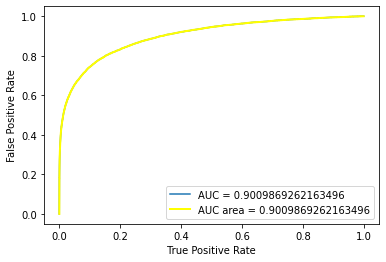

In [ ]:
ax = Visualize_result(lgb.LGBMClassifier(), x_train = x_os, y_train = y_os, x_test = x_test, y_test = y_test)
final_result = ax.class_report()
final_result = ax.confusion_auc()